# 1. Problem presentation 

This notebook illustrates in a simple way that for a dynamical system very sparsely observed, using an advanced data assimilation method (here, an Ensemble Kalman filter, EnKF) rather than a crude one (here, direct substitution of the observed variable with the observation) is essential to estimate the system.

The illustration uses the 3-variable, chaotic Lorenz 63 system (https://en.wikipedia.org/wiki/Lorenz_system). This dynamical model is often used to test data assimilation methods, because it displays a chaotic behavior, as the atmosphere and the ocean do, with very low dimensionality.

We consider the Lorenz equations :

\begin{equation} 
\begin{aligned} \frac{dx}{dt} & = \sigma(y-x) \\ \frac{dy}{dt} & = \rho x - y - xz \\ \frac{dz}{dt} & = -\beta z + xy \end{aligned} 
\end{equation} 

This system is a non-linear differential system of order 1. Using the following parameters, $\sigma=10$, $\beta=\frac{8}{3}$, $\rho=28.0$, it gives rise to a chaotic system. the solution is seen to orbit around two equilibrium points giving two 'regimes'.

In the sequel we will denote the model variable $u = (x, y, z)$, and $u_0 = (x_0,y_0,z_0)$ the initial condition.

The main steps covered below are:
- Simulation and plots of the Lorenz model
- Test model's sensitivity to changes in initial condition and a model parameter
- Experiment assimilation of observation drawn from the reference trajectory into the model with changed initial condition and parameter: direct substitution, and Ensemble Kalman filtering


In [1]:
%matplotlib nbagg
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML
import numpy as np
from scipy import *

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.colors import cnames
import matplotlib.animation as animation

## 1.1 Simulation and plots

Let us start by defining a pyhon function that calculates and draws the trajectory of a particule whose position is defined by the Lorenz equation. This function takes as input the parameters of the Lorenz system ($\sigma$, $\beta$, $\rho$), the initialisation (x0, y0, z0) the temporal window  (max_time) and the visualisation angle (angle).


In [2]:
def solve_lorenz(max_time=4.0, sigma=10.0, beta=8./3, rho=28.0, x0=10., y0=20.,z0=10.5):

    deltat = 1/100.
    res = int(max_time / deltat)
    
    x = np.zeros((res+1))
    y = np.zeros((res+1))
    z = np.zeros((res+1))
      
    x[0]= x0
    y[0]=y0
    z[0]=z0
    for t in range(0,res):
        x[t+1] = x[t]+deltat*sigma*(y[t]-x[t]) 
        y[t+1] = y[t]+deltat*(rho*x[t]-y[t]-x[t]*z[t]) 
        z[t+1] = z[t]+deltat*(-beta*z[t]+x[t]*y[t]) 
    
    return x, y, z


def draw_lorenz(angle=0.0, max_time=4.0, sigma=10.0, beta=8./3, rho=28.0,  x0=10., y0=20.,z0=10.5):

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    # ax.axis('off')

    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    ax.set_title('Lorenz attractor')

    x, y, z = solve_lorenz(max_time=max_time, sigma=sigma, beta=beta, rho=rho,  x0=x0, y0=y0,z0=z0)
    lines = ax.plot(x, y, z, '-')
    plt.setp(lines, linewidth=2)
    
    ax.view_init(30, angle)
    plt.show()

    f, axarr = plt.subplots(3, sharex=True)
    axarr[0].plot(x, label='x')
    axarr[0].legend(loc="upper right")
    axarr[1].plot(y, label='y')
    axarr[1].legend()
    axarr[2].plot(z, label='z')
    axarr[2].legend()
    
    return 

<IPython.core.display.Javascript object>


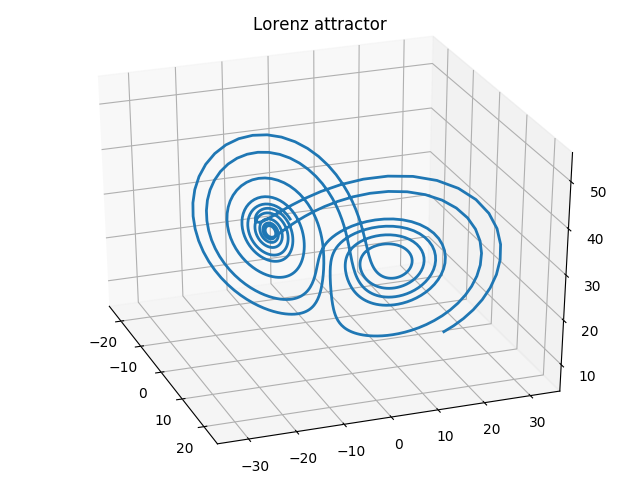

<IPython.core.display.Javascript object>


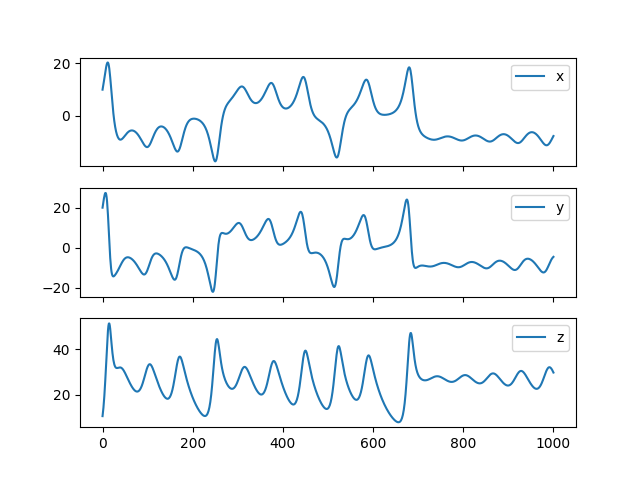

In [3]:
draw_lorenz(angle=-20.0, max_time=10.)

## 1.2 Animation

In [7]:
def stack_lorenz(solve,max_time=4.0, sigma=10.0, beta=8./3, rho=28.0, x0=10., y0=20.,z0=10.5):
    x, y, z = solve(max_time=max_time,sigma=sigma, beta=beta,rho=rho,x0=x0, y0=y0,z0=z0)
    
    res = int(100 * max_time)

    data=np.empty((3,res+1))
    data[0,:]=x[:]
    data[1,:]=y[:]
    data[2,:]=z[:]
    return data

def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

<IPython.core.display.Javascript object>


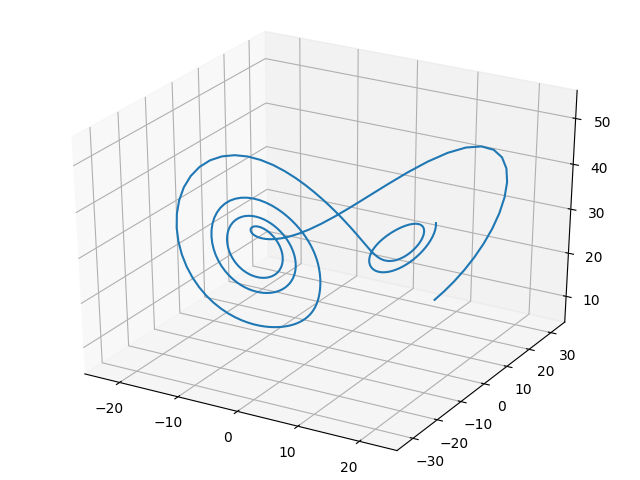

In [8]:

max_time = 10.0

fig = plt.figure()
ax  = p3.Axes3D(fig)

ax.set_xlim3d((-25., 25.))
ax.set_ylim3d((-35., 35.))
ax.set_zlim3d((5., 55.))

data = [stack_lorenz(solve_lorenz,max_time=max_time)]

lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

line_ani = animation.FuncAnimation(fig, update_lines, 1001, fargs=(data, lines),
                                   interval=50, blit=False)

--------------------------------------------------------------------------------------------------

# 2. Reference simulation and perturbation

Use the following lines to study the sensibility of the solution to inaccurate initial condition and/or inaccurate parameters


## 2.1 Lorenz model with inaccurate initial condition

In [9]:
def draw_lorenz_comparison(angle=-20.0, max_time=10.0, sigma_ref=10.0, beta_ref=8./3, rho_ref=28.0,  
                           x0_ref=10., y0_ref=20.,z0_ref=10.5,
                           sigma_inac=10.0, beta_inac=8./3, rho_inac=28.0,  
                           x0_inac=10., y0_inac=20.,z0_inac=10.5):
    
    
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    # ax.axis('off')

    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    ax.set_title('Lorenz attractor')

    x_ref, y_ref, z_ref = solve_lorenz(max_time=max_time, sigma=sigma_ref, beta=beta_ref, rho=rho_ref,
                                x0=x0_ref, y0=y0_ref,z0=z0_ref)
    x_inac,y_inac,z_inac = solve_lorenz(max_time=max_time, sigma=sigma_inac, beta=beta_inac, rho=rho_inac,
                                x0=x0_inac, y0=y0_inac,z0=z0_inac)
    lines_ref = ax.plot(x_ref, y_ref, z_ref, '-')
    lines_inac = ax.plot(x_inac, y_inac, z_inac, '-')
    plt.setp(lines_ref, linewidth=2,label='reference')
    plt.setp(lines_inac, linewidth=2,label='inacurrate')
    ax.view_init(30, angle)
    plt.show()
    plt.legend()

    f, axarr = plt.subplots(3, sharex=True)
    axarr[0].plot(x_ref, label='x reference')
    axarr[0].plot(x_inac, label='x inacurrate')
    axarr[0].legend(loc="upper right")
    axarr[1].plot(y_ref, label='y reference')
    axarr[1].plot(y_inac, label='y inacurrate')
    axarr[1].legend(loc="upper right")
    axarr[2].plot(z_ref, label='z reference')
    axarr[2].plot(z_inac, label='z inacurrate')
    axarr[2].legend(loc="upper right")
    
    return 

<IPython.core.display.Javascript object>


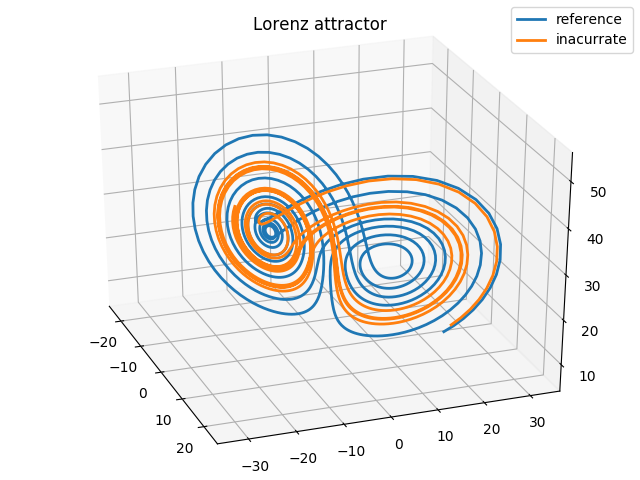

<IPython.core.display.Javascript object>


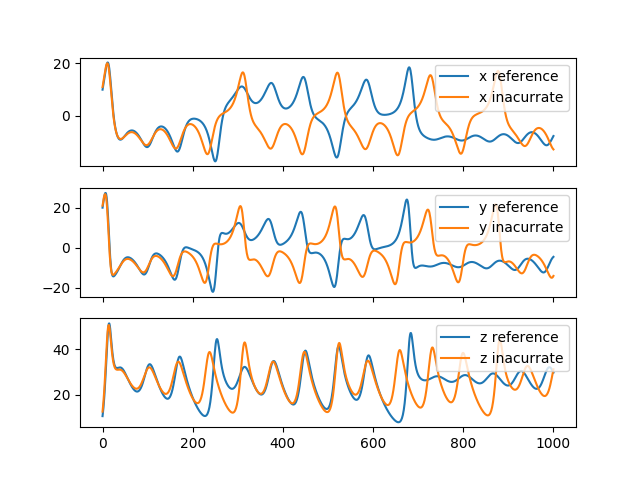

In [10]:
draw_lorenz_comparison(x0_inac=11., y0_inac=21.,z0_inac=12.5)



## 2.2 Lorenz model with inaccurate parameters


<IPython.core.display.Javascript object>


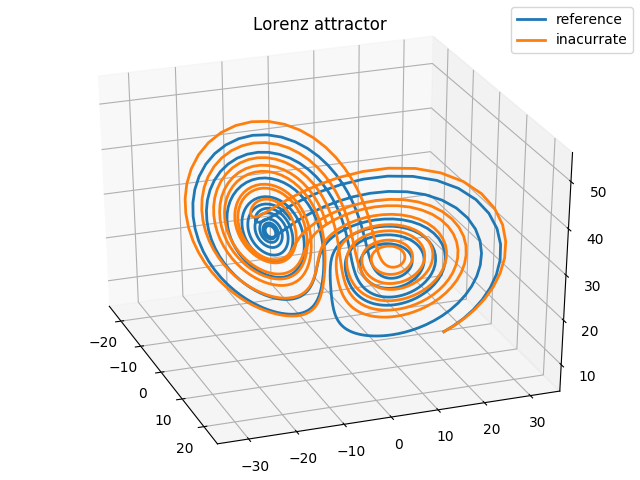

<IPython.core.display.Javascript object>


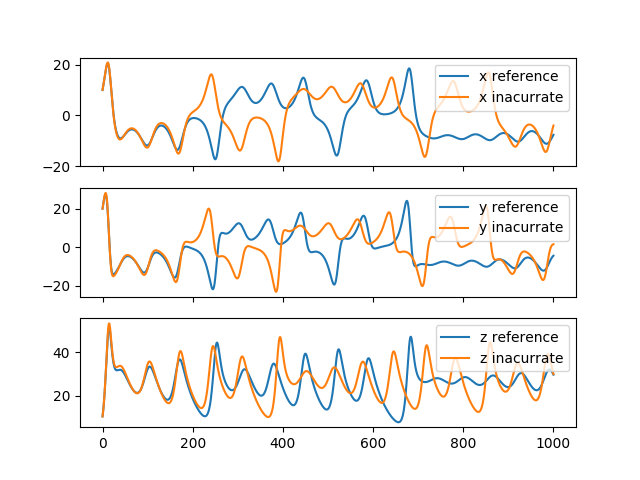

In [11]:
draw_lorenz_comparison(sigma_inac=10.0, beta_inac=8./3, rho_inac=29.0)

## 2.3 Lorenz model with inacurrate conditions and inacurrate parameters

In [12]:
# to be done

---------------------------------------------------------------------------------------

# 3. Data assimilation

We now turn to data assimilation. To do so, we will perform twin experiments.
We assume our model is inaccurate, and the initial condition is not perfectly known. To mimic this, we assimilate observations extracted from the reference simulation ($\rho=28$, initial condition = (1.5, -1.5, 21) ) into an unperfect model ($\rho=29$) initialized with unperfect conditions : the background is set to (3, -3, 21).

We first consider the case where ALL variables (x, but also y and z) are observed at all times.

In [13]:
x_obs, y_obs, z_obs = solve_lorenz(x0=1.5, y0=-1.5,z0=21)
x_b = 3
y_b = -3
z_b = 21
x_model, y_model, z_model = solve_lorenz(x0=x_b, y0=y_b,z0=z_b,rho=29.)



## 3.1 First data assimilation experiment: Extended Kalman filter
Implement the Extended Kalman filter algorithm, and validate it in the twin experiments framework: initialise the algorithm with the background, use the observations, and check that your analysis $u_a$ is a good approximation of the exact solution $u_ref$. Provide figures to illustrate this point (at least one figure showing the evolution of the reference, the background and the analysis trajectories during the time window [0, 4]).

In [14]:
def lorenz_step(sigma=10.0, beta=8./3, rho=28.0, x=0, y=0,z=0,dt=0.01): #one model step(from state at k*dt to state at (k+1)*dt)
    x = x+dt*sigma*(y-x) 
    y = y+dt*(rho*x -y -x*z) 
    z = z+dt*(-beta*z + x*y)
    return np.matrix([x,y,z])

def jacobian_lorenz(sigma=10.0, beta=8./3, rho=28.0, x=10., y=20.,z=10.5): #jacobian matrix for the model(one lorenz step)
    Jacobian = np.matrix([[1-sigma*dt,sigma*dt,0],[dt*(rho-z),1 - dt,-x*dt],[y*dt,x*dt,1-beta*dt]])
    return Jacobian


def obsOperator(X):#observation operator H s.t H(xk) = yk
    return X  #case where ALL variables (x, but also y and z) are observed at all times

def jacobian_obs(X): #Jacobian matrix of obsOperator
    return np.eye(3) #case where ALL variables (x, but also y and z) are observed at all times

#definition of the two step of the algorithm
def extendedKalman_forecast(xa, P, y, R, Q, model, jacobian_model,rho,sigma,beta): 
    xf = model(rho = rho,sigma = sigma, beta = beta, x=xa[0,0],y=xa[0,1],z=xa[0,2]) 
    M = jacobian_model(rho = rho,sigma = sigma, beta = beta, x=xa[0,0],y=xa[0,1],z=xa[0,2])
    P = np.dot(M,np.dot(P,M.T)) + Q
    return xf, P
def extendedKalman_analysis(xf, P, y, R,obsOperator, jacobian_obs):
    innov = y - obsOperator(xf)
    H = jacobian_obs(xf)
    S = R + np.dot(H, np.dot(P,H.T))  
    K = np.dot(P, np.dot(H.T,np.linalg.inv(S)))    # Kalman gain
    xa = xf + np.dot(K,innov.T).T
    I = np.matrix(np.eye(P.shape[0])) # identity matrix
    P = np.dot(I - np.dot(K,H),P)
    return xa, P

<IPython.core.display.Javascript object>


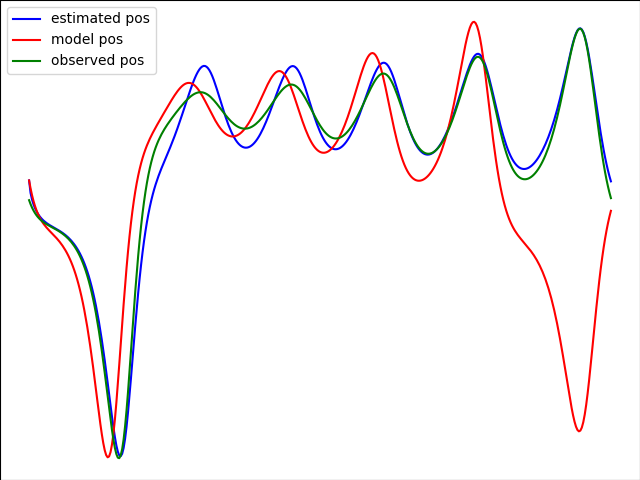

<IPython.core.display.Javascript object>


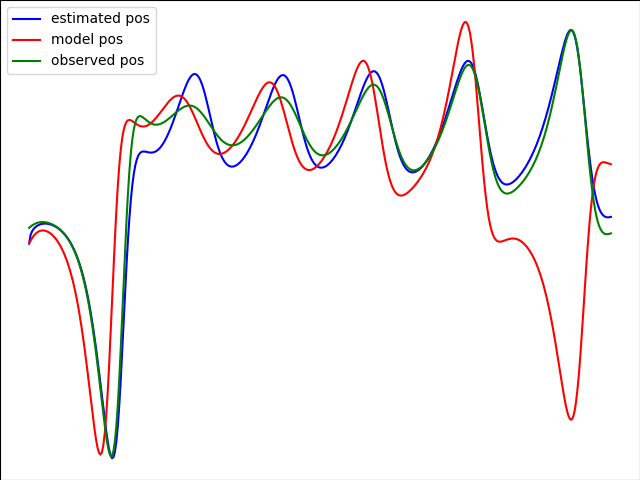

<IPython.core.display.Javascript object>


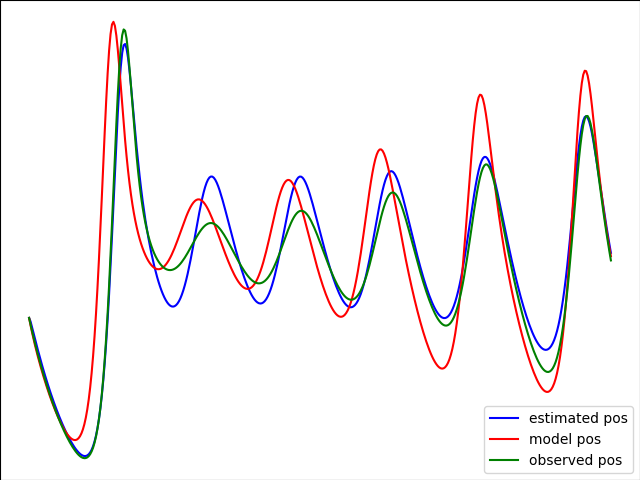

In [15]:
from pylab import *
#save the image ?
saveImage = 0
nameImage = 'test'
#initialization of different parameters
    #time variables
max_time=4.0
dt = 1/100.
res = int(max_time / dt)
times = np.arange(res+1) 
    #state variable
x = np.zeros((res+1))
y = np.zeros((res+1))
z = np.zeros((res+1))
    #background
x[0]= x_b
y[0]=y_b
z[0]=z_b
    #covariance matrices
P = np.eye(3); #if P =0, P stays at 0
Q = np.zeros((3,3))
R = np.eye(3)
    #lorenz parameters
sigma = 10;rho=29.0;beta=8./3;

#steps of the Extended Kalman filter
for t in range(0,res):
    xa = np.matrix([x[t],y[t],z[t]])
    obs = np.matrix([x_obs[t], y_obs[t], z_obs[t]])
    xf,P = extendedKalman_forecast(xa, P, obs, R,Q, lorenz_step,jacobian_lorenz,rho,sigma,beta) 
    xa,P = extendedKalman_analysis(xf,P,obs,R, obsOperator, jacobian_obs)
    x[t+1]=xa[0,0];y[t+1]=xa[0,1];z[t+1]=xa[0,2];
    
#Show results
#X
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
plt.plot(times,x,'b')
plt.plot(times,x_model,'r')
plt.plot(times, x_obs, 'g')
plt.legend(['estimated pos', 'model pos', 'observed pos'])
plt.xlabel('time')
plt.ylabel('particle position')
plt.title('x position')
plt.show();
#Y
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
plt.plot(times,y,'b')
plt.plot(times,y_model,'r')
plt.plot(times, y_obs, 'g')
plt.legend(['estimated pos', 'model pos', 'observed pos'])
plt.xlabel('time')
plt.ylabel('particle position')
plt.title('y position')
plt.show();
#Z
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
plt.plot(times,z,'b')
plt.plot(times,z_model,'r')
plt.plot(times, z_obs, 'g')
plt.legend(['estimated pos', 'model pos', 'observed pos'])
plt.xlabel('time')
plt.ylabel('particle position')
plt.title('z position')

if saveImage == 1:
    plt.savefig('images/' + nameImage)
plt.show();
    

## 3.2 Second data assimilation experiment: Ensemble Kalman filter
We perform the same experiment as above, same model, same observations, but with an Ensemble Kalman filter (EnKF). The EnKF is a Monte Carlo method, therefore requires the definition of an ensemble (sample) size. An estimation of the observation error variance is also needed.

In [66]:
#IMPORTANCE SAMPLING
xmin = 0; xmax = 2;
samples = 10000;

def g(x):
    return 2*x**2

def f(N):
    return (xmax-xmin)*np.random.random_sample((samples,)) + xmin
    
def q(N):
    #density distribution is (1/5)*ind(0,1) + (4/5)*ind(1,2)
    tmp = np.random.random_sample((samples,)) #N points between 0 and 1
    len1 = len(tmp[tmp<=(1./5)])
    len2 = len(tmp[tmp>(1./5)])
    x1 = np.random.random_sample((len1,))
    qx1 = (1./5)*np.ones((len1,))
    x2 = (xmax-1)*np.random.random_sample((len2,)) + 1
    qx2 = (4./5)*np.ones((len2,))
    return np.concatenate((x1,x2)), np.concatenate((qx1,qx2))


#get sample from qX
x,q = q(samples)

res = mean(g(x)/q)
res/2


TypeError: 'numpy.ndarray' object is not callable

In [67]:
#ENSEMBLE KALMAN FILTER

#definition of the two step of the algorithm
def ensembleKalman_forecast(xa, R, Q, model, jacobian_model,rhoP): 
    xfi = np.zeros(xa.shape)
    N = xa.shape[0]
    M = xa.shape[1]
    for k in range(0,N):
        xfi[k] = model(rho = rhoP, x=xa[k,0],y=xa[k,1],z=xa[k,2]) 
    
    xf = np.matrix([np.mean(xfi[:,0]), np.mean(xfi[:,1]), np.mean(xfi[:,2])])
    P=np.zeros((M,M))
    for k in range(0,N):
        P += np.dot((xfi[k]-xf).T,(xfi[k]-xf))
    P = (1./(N-1))*P
    return xf, xfi, P

def ensembleKalman_analysis(xfi,xf, P, y, R,obsOperator, jacobian_obs):
    N = xfi.shape[0]
    M = xfi.shape[1]
    xai= np.zeros(xfi.shape)
    PHt = np.zeros(R.shape)
    for k in range(0,N):
        PHt += np.dot((xfi[k]-xf).T,obsOperator(xfi[k])- obsOperator(xf))
    PHt = (1./(N-1))*PHt
    
    HPHt = np.zeros(R.shape)
    for k in range(0,N):
        HPHt += np.dot((obsOperator(xfi[k])-obsOperator(xf)).T,obsOperator(xfi[k])- obsOperator(xf))
    HPHt = (1./(N-1))*HPHt
    
    K = np.dot(PHt,np.linalg.inv(HPHt + R))
    y = y  #RAJOUTER LE BRUIT AVEC R
    
    for k in range(0,N):
        xai[k] = xfi[k] + np.dot(K,(y - obsOperator(xfi[k])).T)
    
    xa = np.matrix([np.mean(xai[:,0]), np.mean(xai[:,1]), np.mean(xai[:,2])])
    return xa, xai


<IPython.core.display.Javascript object>


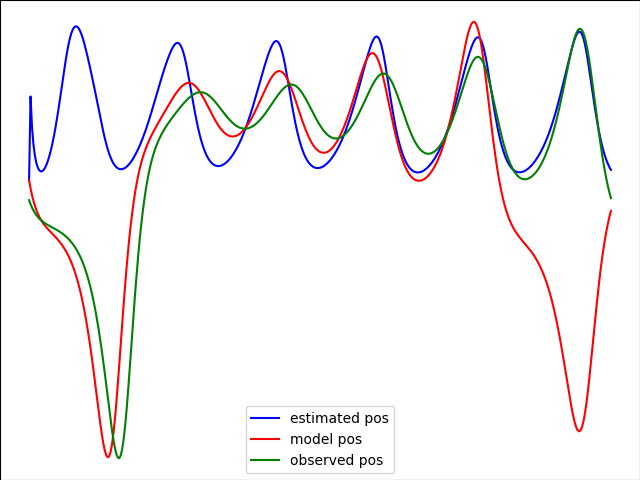

<IPython.core.display.Javascript object>


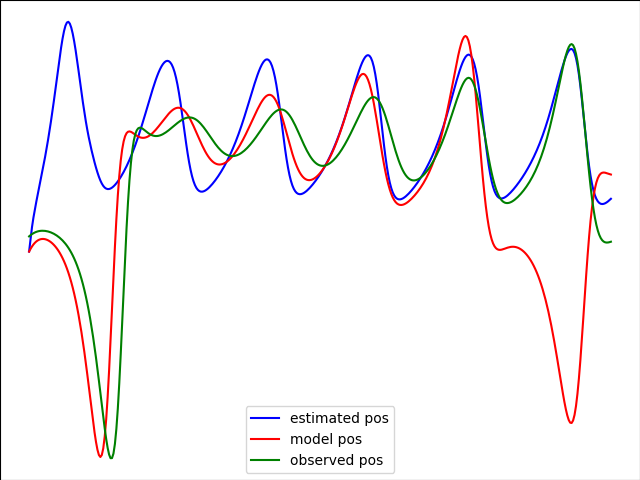

<IPython.core.display.Javascript object>


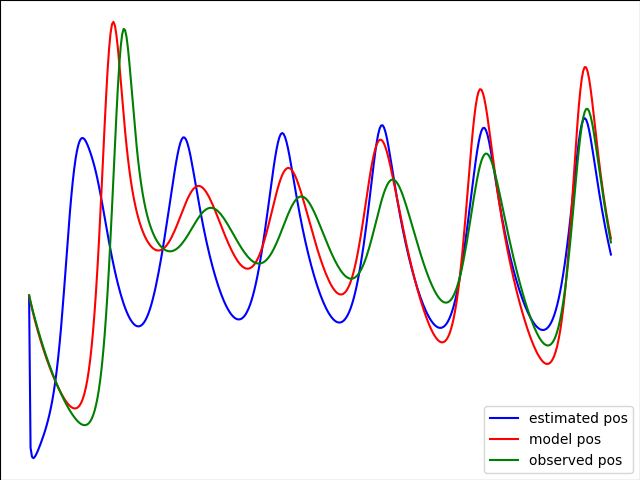

In [75]:
#save the image ?
saveImage = 0
nameImage = 'test'
#initialization of different parameters
    #time variables
max_time=4.0
dt = 1/100.
res = int(max_time / dt)
times = np.arange(res+1) 
    #state variable
x = np.zeros((res+1))
y = np.zeros((res+1))
z = np.zeros((res+1))
    #background
x[0]= x_b
y[0]=y_b
z[0]=z_b
background=np.array([x_b,y_b,z_b])
    #covariance matrices
P = 1000*np.eye(3); #if P =0, P stays at 0
Q = np.zeros((3,3))
R = 1000*np.eye(3)
    #lorenz parameters
sigma = 10;rho=29.0;beta=8./3;

#number of samples
samples = 10

#SAMPLING
mean = background
cov = P  # diagonal covariance
x0 = np.random.multivariate_normal(mean, cov, samples)

#steps of the EnsembleKalman filter
xai = x0
for t in range(0,res):
    obs = np.matrix([x_obs[t], y_obs[t], z_obs[t]])
    xf,xfi,P = ensembleKalman_forecast(xai, R, Q, lorenz_step, jacobian_lorenz,rho)
    xa,xai =ensembleKalman_analysis(xfi,xf, P, y[t], R,obsOperator, jacobian_obs)
    x[t+1]=xa[0,0];y[t+1]=xa[0,1];z[t+1]=xa[0,2];

#Show results
#X
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
plt.plot(times,x,'b')
plt.plot(times,x_model,'r')
plt.plot(times, x_obs, 'g')
plt.legend(['estimated pos', 'model pos', 'observed pos'])
plt.xlabel('time')
plt.ylabel('particle position')
plt.title('x position')
plt.show();
#Y
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
plt.plot(times,y,'b')
plt.plot(times,y_model,'r')
plt.plot(times, y_obs, 'g')
plt.legend(['estimated pos', 'model pos', 'observed pos'])
plt.xlabel('time')
plt.ylabel('particle position')
plt.title('y position')
plt.show();
#Z
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
plt.plot(times,z,'b')
plt.plot(times,z_model,'r')
plt.plot(times, z_obs, 'g')
plt.legend(['estimated pos', 'model pos', 'observed pos'])
plt.xlabel('time')
plt.ylabel('particle position')
plt.title('z position')

if saveImage == 1:
    plt.savefig('images/' + nameImage)
plt.show();
    

## 3.3 Third data assimilation experiment: Variational approaches
Similarly, implement a variational algorithm for the same twin experiments framework. To avoid adjoint coding, consider using a gradient-free minimisation algorithm, such as simulated annealing (see Wikipedia). Feel free to use built-in functions for that (scipy.optimize.anneal in Python).
Similarly provide at least one figure showing reference, background and analysis trajectories over time. Provide also a figure showing the deacrease of the cost function with the iteration number.

In [32]:
#Simulation annealing algorithm
def acceptanceProbability(currentEnergy, newEnergy,temperature):
    if newEnergy < currentEnergy: #here energy is the norm, we look for a minimum
        return 1.0
    else:
        return np.exp((currentEnergy-newEnergy)/temperature)

#definition of the cost function J to be minimized
def matSquareNorm(x,M): #x.T*M*x
    return np.dot(x,np.dot(M,x.T))

def Jb(X0,Xb,Pb):
    return 0.5*matSquareNorm(X0-Xb,inv(Pb))

def Jo(X,Xobs,R):
    return matSquareNorm(obsOperator(X-Xobs),inv(R))

#initializations
temperature = 1000
coolingRate = 0.003

background = np.matrix([x_b,y_b,z_b])
means = np.array([0,0,0])
bgErrorVariances = np.matrix([P[0,0],P[1,1],P[2,2]]) #idea :get a background error in x,y,z from the variances defined in P
                                                   #here, we suppose that there is no dependency between varialbles, o.w 
                                                   #define a background matrix to get the 3 errors.
#initial solution
rho = 29.
Xcurrent = background + 1*np.random.normal(loc=means,scale=np.sqrt(bgErrorVariances))
x_current, y_current, z_current = solve_lorenz(rho=rho, x0=Xcurrent[0,0], y0=Xcurrent[0,1],z0=Xcurrent[0,2])
#background cost
Jcurrent = Jb(Xcurrent,background,P)
#print('Jb = ',Jcurrent)
#observation cost
for k in range(0,x_current.shape[0]):
    Xk = np.array([x_current[k], y_current[k], z_current[k]])
    Xobs = np.array([x_obs[k], y_obs[k], z_obs[k]])
    Jcurrent += Jo(Xk,Xobs,R)
    #print('Jcurrent = ',Jcurrent)
Xbest = Xcurrent
Jbest = Jcurrent
#print('Xcurrent =', Xcurrent)
#print('Jcurrent1 =', Jcurrent)
cmpt = 0
while temperature >1: #change bg by Xcurrent
    cmpt +=1
    #process to define the neighbour: varies randomly considering variances in P
    index = int(3*np.random.rand())#random integer  between 0 and 2 to choose which coordinate of x0 to randomly modify
    indexes = np.zeros(3); indexes[index] = 1;
    Xneighbour = Xcurrent + 10*indexes*np.random.normal(loc=means,scale=np.sqrt(bgErrorVariances))
    x_neighbour, y_neighbour, z_neighbour = solve_lorenz(rho=rho, x0=Xneighbour[0,0], y0=Xneighbour[0,1],z0=Xneighbour[0,2])
    #print('Xneighbour =', Xneighbour)
    Jneighbour = Jb(Xneighbour,background,P)
    #observation cost
    for k in range(0,x_neighbour.shape[0]):
        Xk = np.array([x_neighbour[k], y_neighbour[k], z_neighbour[k]])
        Jneighbour += Jo(Xk,Xobs,R)
    #print(Jneighbour)
    #update the current solution depending on probability acceptance(update the neighbour)
    if (acceptanceProbability(Jcurrent,Jneighbour, temperature)>np.random.rand()):
        #print('accepted')
        #print('Jneighbour =',Jneighbour, Jbest)
        Xcurrent = Xneighbour
        #update the best solution so far
        if Jneighbour < Jbest:
            Xbest = Xcurrent
            Jbest = Jneighbour
#            print('Jbest =',Jbest)
    temperature *= 1-coolingRate
    #print('Jbest =',Jbest)
print('temperature = ',temperature)
print(Xbest, Jbest)

temperature =  0.9973879496507521
[[ 14.82814847 -24.55395696   9.10434566]] [[ -1.21191032e+21]]



## 3.4 additional questions

### Sensitivity of the solutions
For both extended and ensemble Kalman filter, look at :
- the sensitivity of the solution to the errors in the background
- the sensitivity of the solution to the model error Q. What is the impact of excluding the model error correlations ? What is the impact of increasing the magnitude of model error variances ?

Just for the Ensemble Kalman filter, what is the effect of changing :
- the size of the ensemble ?
- the size of the observation perturbation ?

### Less observations
- What happens if observations are not available for every variable (x, y, z) but only for the first variable x? Perform some experiments and provide some figures to illustrate them.
- What happens if observations are not available at every time? Perform some experiments and provide some figures to illustrate them.
- What happens if observations are not exact but corrupted by some (random) measurement errors? Perform some experiments and provide some figures to illustrate them.
